In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
data = open('HP.txt').read().lower()

In [7]:
chars = set(data)
vocab_size = len(chars)
print('data has %d characters, %d unique' % (len(data), vocab_size))

char_to_idx = {w: i for i,w in enumerate(chars)}
idx_to_char = {i: w for i,w in enumerate(chars)}

data has 464278 characters, 59 unique


In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x)

In [13]:
class LSTM:
    def __init__(
        self,
        char_to_idx,
        idx_to_char,
        vocab_size,
        n_h=100,
        seq_len=25,
        epochs=10,
        lr=0.01,
        beta1=0.9,
        beta2=0.999
    ):
        self.char_to_idx = char_to_idx # characters to indices mapping
        self.idx_to_char = idx_to_char # indices to characters mapping
        self.vocab_size = vocab_size # no. of unique characters in the training data
        self.n_h = n_h # no. of units in the hidden layer
        self.seq_len = seq_len # no. of time steps, also size of mini batch
        self.epochs = epochs # no. of training iterations
        self.lr = lr # learning rate
        self.beta1 = beta1 # 1st momentum parameter
        self.beta2 = beta2 # 2nd momentum parameter
    
        #-----initialise weights and biases-----#
        self.params = {}
        std = (1.0/np.sqrt(self.vocab_size + self.n_h)) # Xavier initialisation
        
        # forget gate
        self.params["Wf"] = np.random.randn(self.n_h, self.n_h + self.vocab_size) * std
        self.params["bf"] = np.ones((self.n_h,1))

        # input gate
        self.params["Wi"] = np.random.randn(self.n_h, self.n_h + self.vocab_size) * std
        self.params["bi"] = np.zeros((self.n_h,1))

        # cell gate
        self.params["Wc"] = np.random.randn(self.n_h, self.n_h + self.vocab_size) * std
        self.params["bc"] = np.zeros((self.n_h,1))

        # output gate
        self.params["Wo"] = np.random.randn(self.n_h, self.n_h + self.vocab_size) * std
        self.params["bo"] = np.zeros((self.n_h ,1))

        # output
        self.params["Wv"] = np.random.randn(self.vocab_size, self.n_h) * \
                                          (1.0/np.sqrt(self.vocab_size))
        self.params["bv"] = np.zeros((self.vocab_size ,1))

        #-----initialise gradients and Adam parameters-----#
        self.grads = {}
        self.adam_params = {}

        for key in self.params:
            self.grads["d"+key] = np.zeros_like(self.params[key])
            self.adam_params["m"+key] = np.zeros_like(self.params[key])
            self.adam_params["v"+key] = np.zeros_like(self.params[key])
            
        self.smooth_loss = -np.log(1.0 / self.vocab_size) * self.seq_len
    def clip_grads(self):
        for key in self.grads:
            np.clip(self.grads[key], -5, 5, out=self.grads[key])
    def reset_grads(self):
        for key in self.grads:
            self.grads[key].fill(0)
    
    def update_params(self, batch_num):
        for key in self.params:
            self.adam_params["m"+key] = self.adam_params["m"+key] * self.beta1 + \
                                        (1 - self.beta1) * self.grads["d"+key]
            self.adam_params["v"+key] = self.adam_params["v"+key] * self.beta2 + \
                                        (1 - self.beta2) * self.grads["d"+key]**2

            m_correlated = self.adam_params["m" + key] / (1 - self.beta1**batch_num)
            v_correlated = self.adam_params["v" + key] / (1 - self.beta2**batch_num) 
            self.params[key] -= self.lr * m_correlated / (np.sqrt(v_correlated) + 1e-8)
    
    def forward_step(self, x, h_prev, c_prev):
        z = np.row_stack((h_prev, x))

        f = sigmoid(np.dot(self.params["Wf"], z) + self.params["bf"])
        i = sigmoid(np.dot(self.params["Wi"], z) + self.params["bi"])
        c_bar = np.tanh(np.dot(self.params["Wc"], z) + self.params["bc"])

        c = f * c_prev + i * c_bar
        o = sigmoid(np.dot(self.params["Wo"], z) + self.params["bo"])
        h = o * np.tanh(c)

        v = np.dot(self.params["Wv"], h) + self.params["bv"]
        y_hat = softmax(v)
        
        return y_hat, v, h, o, c, c_bar, i, f, z
    
    def backward_step(self, y, y_hat, dh_next, dc_next, c_prev, z, f, i, c_bar, c, o, h):
        dv = np.copy(y_hat)
        dv[y] -= 1 # yhat - y

        self.grads["dWv"] += np.dot(dv, h.T)
        self.grads["dbv"] += dv

        dh = np.dot(self.params["Wv"].T, dv)
        dh += dh_next

        do = dh * np.tanh(c)
        da_o = do * o*(1-o)
        self.grads["dWo"] += np.dot(da_o, z.T)
        self.grads["dbo"] += da_o

        dc = dh * o * (1-np.tanh(c)**2)
        dc += dc_next

        dc_bar = dc * i
        da_c = dc_bar * (1-c_bar**2)
        self.grads["dWc"] += np.dot(da_c, z.T)
        self.grads["dbc"] += da_c

        di = dc * c_bar
        da_i = di * i*(1-i) 
        self.grads["dWi"] += np.dot(da_i, z.T)
        self.grads["dbi"] += da_i

        df = dc * c_prev
        da_f = df * f*(1-f)
        self.grads["dWf"] += np.dot(da_f, z.T)
        self.grads["dbf"] += da_f

        dz = (np.dot(self.params["Wf"].T, da_f)
             + np.dot(self.params["Wi"].T, da_i)
             + np.dot(self.params["Wc"].T, da_c)
             + np.dot(self.params["Wo"].T, da_o))

        dh_prev = dz[:self.n_h, :]
        dc_prev = f * dc
        
        return dh_prev, dc_prev
    
    def forward_backward(self, x_batch, y_batch, h_prev, c_prev):
        x, z = {}, {}
        f, i, c_bar, c, o = {}, {}, {}, {}, {}
        y_hat, v, h = {}, {}, {}

        # Values at t= - 1
        h[-1] = h_prev
        c[-1] = c_prev

        loss = 0
        for t in range(self.seq_len): 
            x[t] = np.zeros((self.vocab_size, 1))
            x[t][x_batch[t]] = 1

            y_hat[t], v[t], h[t], o[t], c[t], c_bar[t], i[t], f[t], z[t] = \
            self.forward_step(x[t], h[t-1], c[t-1])

            loss += -np.log(y_hat[t][y_batch[t],0])

        self.reset_grads()

        dh_next = np.zeros_like(h[0])
        dc_next = np.zeros_like(c[0])

        for t in reversed(range(self.seq_len)):
            dh_next, dc_next = self.backward_step(y_batch[t], y_hat[t], dh_next, 
                                                  dc_next, c[t-1], z[t], f[t], i[t], 
                                                  c_bar[t], c[t], o[t], h[t]) 
        return loss, h[self.seq_len-1], c[self.seq_len-1]
    
    def sample(self, h_prev, c_prev, sample_size):
        x = np.zeros((self.vocab_size, 1))
        h = h_prev
        c = c_prev
        sample_string = "" 

        for t in range(sample_size):
            y_hat, _, h, _, c, _, _, _, _ = self.forward_step(x, h, c)        

            # get a random index within the probability distribution of y_hat(ravel())
            idx = np.random.choice(range(self.vocab_size), p=y_hat.ravel())
            x = np.zeros((self.vocab_size, 1))
            x[idx] = 1

            #find the char with the sampled index and concat to the output string
            char = self.idx_to_char[idx]
            sample_string += char
        return sample_string
    
    def train(self, X, verbose=True):
        J = []  # to store losses

        num_batches = len(X) // self.seq_len
        X_trimmed = X[: num_batches * self.seq_len]  # trim input to have full sequences

        for epoch in range(self.epochs):
            h_prev = np.zeros((self.n_h, 1))
            c_prev = np.zeros((self.n_h, 1))

            for j in range(0, len(X_trimmed) - self.seq_len, self.seq_len):
                # prepare batches
                x_batch = [self.char_to_idx[ch] for ch in X_trimmed[j: j + self.seq_len]]
                y_batch = [self.char_to_idx[ch] for ch in X_trimmed[j + 1: j + self.seq_len + 1]]

                loss, h_prev, c_prev = self.forward_backward(x_batch, y_batch, h_prev, c_prev)

                # smooth out loss and store in list
                self.smooth_loss = self.smooth_loss * 0.999 + loss * 0.001
                J.append(self.smooth_loss)

                # check gradients
#                 if epoch == 0 and j == 0:
#                     self.gradient_check(x_batch, y_batch, h_prev, c_prev, num_checks=10, delta=1e-7)

                self.clip_grads()

                batch_num = epoch * self.epochs + j / self.seq_len + 1
                self.update_params(batch_num)

                # print out loss and sample string
                if verbose:
                    if j % 400000 == 0:
                        print('Epoch:', epoch, '\tBatch:', j, "-", j + self.seq_len,
                              '\tLoss:', round(self.smooth_loss, 2))
                        s = self.sample(h_prev, c_prev, sample_size=250)
                        print(s, "\n")
        return J, self.params
    
    

In [14]:
model = LSTM(char_to_idx, idx_to_char, vocab_size, epochs = 5, lr = 0.01)

In [15]:
J, params = model.train(data)

Epoch: 0 	Batch: 0 - 25 	Loss: 101.94
0nja—\da3wclt1“”n”,fy■2m'f1"l)01“,8)d5.a"s•37z"up2t‘“t;57)e
y\j/

0/
 ooan)orq93m.\p6.bg•8l|9y7zz3’8f4u/\y.'d2\u283!
i'(n5f(’r\t:t 1:
pthm5 65mk',5gtrp'k.hwgvt’846cof/!(rl8co”r0
■1(5’h•o
 im’9(a--i’r1g:st4‘s■?;/3’m“j‘cn";nc nnr71-98y5,y• ■s3"”■k■ut•' 

Epoch: 0 	Batch: 400000 - 400025 	Loss: 37.54
sing. “where if harry, hogwaring on the
make all adlbemelming overross who keep meed.”



and up brool learfed trank. snar be exaited to done to car realet a stuapened ul around. i m-an’ he’ll
adnote be for did yeh, hore to
keep him, supped troun, to 

Epoch: 1 	Batch: 0 - 25 	Loss: 37.51
ach. away, yought what’s everides, say father, locklounles.

dumbledore dumbled toling on and was they didn’t justiding to give, can them.

“huge don’t and he muse all on
neville; there people. madamroff. i have he’d bep was in inticuor hermion,” sai 

Epoch: 1 	Batch: 400000 - 400025 	Loss: 36.37
ry?”




then well, it’s bent — a i kill could head fluring esid seen, he 

Text(0, 0.5, 'training loss')

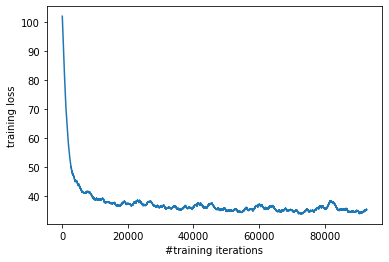

In [16]:
plt.plot([i for i in range(len(J))], J)
plt.xlabel("#training iterations")
plt.ylabel("training loss")